---
## Step one: load the required libraries

In [1]:
import nltk
import matplotlib.pyplot as plt
import re
import string
import unicodedata


from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from pyspark.ml import Pipeline
from pyspark.ml.classification import (
    NaiveBayes,
)

from pyspark.ml.evaluation import (
    MulticlassClassificationEvaluator,
)
from pyspark.ml.feature import (
    CountVectorizer,
    IDF,
    Normalizer,
    StopWordsRemover,
    StringIndexer,
    Tokenizer,
    VectorAssembler,
)
import pyspark.sql.functions as F
from pyspark.ml.stat import Correlation
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    concat_ws
)
from pyspark.sql.types import (
    StructField, 
    StructType, 
    ArrayType, 
    IntegerType, 
    StringType
)

import seaborn as sns

# Create Spark session
spark = SparkSession.builder\
    .appName("DataClassificationGroupProject") \
    .getOrCreate()
# Set the logging level to ERROR
spark.sparkContext.setLogLevel("ERROR")
nltk.download('wordnet', quiet=True)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/08/04 13:54:21 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


True

## Step Two: load the data

In [2]:
all_data = spark.read.csv(
    "adult.csv", 
    escape='"',
    header=True, 
    inferSchema=True,
)

# Rename columns the . in the name causes issues
all_data = all_data.withColumnRenamed('marital-status', 'marital_status')
all_data = all_data.withColumnRenamed('educational-num', 'education_num')
all_data = all_data.withColumnRenamed('capital-gain', 'capital_gain')
all_data = all_data.withColumnRenamed('capital-loss', 'capital_loss')
all_data = all_data.withColumnRenamed('hours-per-week', 'hours_per_week')
all_data = all_data.withColumnRenamed('native-country', 'native_country')
all_data = all_data.withColumnRenamed('gender', 'sex')

## Step Three: Explore the data

In [3]:
print("Train data schema:")
all_data.printSchema()
print("\nTrain data row sample:")
all_data.show(10)
print(f"\nNumber of rows in train_data: {all_data.count()}")
print("\nUnique authors in train_data:")
all_data.groupBy("sex").count().show()

Train data schema:
root
 |-- age: integer (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: integer (nullable = true)
 |-- education: string (nullable = true)
 |-- education_num: integer (nullable = true)
 |-- marital_status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- capital_gain: integer (nullable = true)
 |-- capital_loss: integer (nullable = true)
 |-- hours_per_week: integer (nullable = true)
 |-- native_country: string (nullable = true)
 |-- income: string (nullable = true)


Train data row sample:
+---+----------------+------+------------+-------------+------------------+-----------------+-------------+-----+------+------------+------------+--------------+--------------+------+
|age|       workclass|fnlwgt|   education|education_num|    marital_status|       occupation| relationship| race|   sex|capital_gain|capital

## => `Random Forest Classifier`

### `Predict income from combining categorical and numeric features`

Accuracy:  0.8479401358330961
Weighted Precision:  0.8408305515776068
Weighted Recall:  0.8479401358330961
F1 Score:  0.8365590961711532
This model couldn't predict  3739  cases


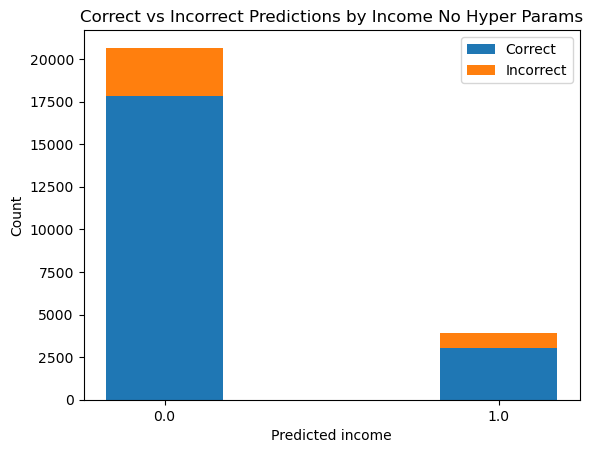

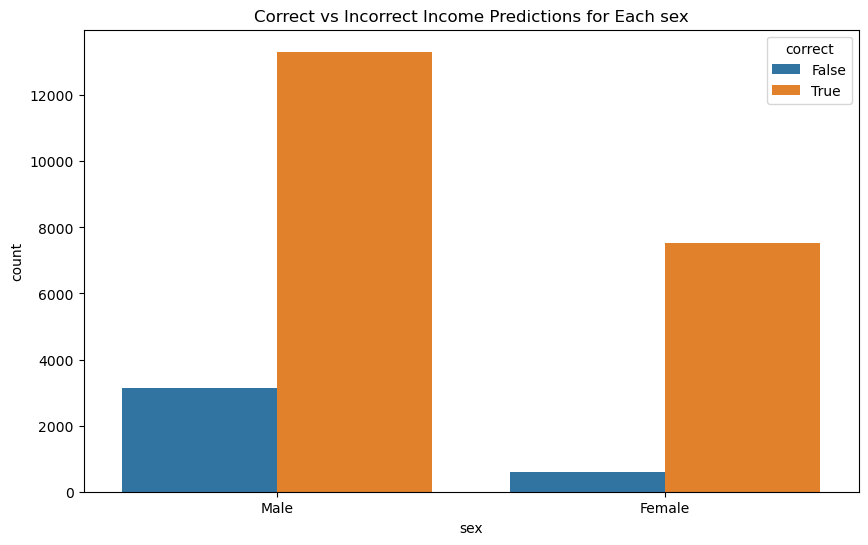

In [4]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, IndexToString
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


# Split the data into train and test
(train_data, test_data) = all_data.randomSplit([0.50, 0.50], seed=1234)

categorical_columns = ["workclass", "education", "marital_status", "occupation", "relationship", "race", "sex", "native_country"]

# StringIndexer for categorical columns
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index", handleInvalid="keep").fit(train_data) for column in categorical_columns]

# StringIndexer for the income column (we need to transform this independently as it's our target variable)
income_indexer = StringIndexer(inputCol="income", outputCol="income_index")


# Replace categorical columns with indexed columns
numeric_columns = [column+"_index" for column in categorical_columns]

# Include any other numeric columns from your DataFrame in your features
numeric_columns.extend(["age", "fnlwgt", "education_num", "capital_gain", "capital_loss", "hours_per_week"])

# VectorAssembler for feature columns
assembler = VectorAssembler(inputCols=numeric_columns, outputCol='features')

#print("Input Columns: ", assembler.getInputCols())
#print("Output Column: ", assembler.getOutputCol())

# Initialize Random Forest
rf = RandomForestClassifier(labelCol='income_index', featuresCol='features', maxBins=43)

# Pipeline stages
stages = indexers + [assembler,income_indexer, rf]

# Initialize Pipeline
pipeline = Pipeline(stages=stages)


# Train model
model = pipeline.fit(train_data)

# Predict
predictions = model.transform(test_data)

# Define the evaluators
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="income_index", predictionCol="prediction", metricName="accuracy")
precision_evaluator = MulticlassClassificationEvaluator(labelCol="income_index", predictionCol="prediction", metricName="weightedPrecision")
recall_evaluator = MulticlassClassificationEvaluator(labelCol="income_index", predictionCol="prediction", metricName="weightedRecall")
f1_evaluator = MulticlassClassificationEvaluator(labelCol="income_index", predictionCol="prediction", metricName="f1")

# Compute metrics
accuracy = accuracy_evaluator.evaluate(predictions)
precision = precision_evaluator.evaluate(predictions)
recall = recall_evaluator.evaluate(predictions)
f1_score = f1_evaluator.evaluate(predictions)

# Print metrics
print("Accuracy: ", accuracy)
print("Weighted Precision: ", precision)
print("Weighted Recall: ", recall)
print("F1 Score: ", f1_score)

#SHOW Prediction Visuals & Graphs

# Define the converter
converter = IndexToString(inputCol="prediction", outputCol="predictedLabel", labels=model.stages[-2].labels)

# Apply the converter to the predictions
converted = converter.transform(predictions)

# Create a DataFrame with just the original and predicted values
results = converted.select("income", "predictedLabel").filter("income <> predictedLabel")

# Show the DataFrame
print("This model couldn't predict ",results.count(), " cases")


# Extract the labels and counts
label_counts = predictions.groupBy("prediction", "income_index").count().orderBy("prediction", "income_index").collect()
predicted_labels = sorted(set(row["prediction"] for row in label_counts))
actual_labels = sorted(set(row["income_index"] for row in label_counts))

# correct and incorrect count lists
correct_counts = [0] * len(predicted_labels)
incorrect_counts = [0] * len(predicted_labels)

# counts based on the predictions
for row in label_counts:
    pred_label_idx = predicted_labels.index(row["prediction"])
    if row["prediction"] == row["income_index"]:
        correct_counts[pred_label_idx] = row["count"]
    else:
        incorrect_counts[pred_label_idx] = row["count"]

# bar chart
plt.figure()
bar_width = 0.35
index = range(len(predicted_labels))
plt.bar(index, correct_counts, bar_width, label="Correct")
plt.bar(index, incorrect_counts, bar_width, bottom=correct_counts, label="Incorrect")
plt.xlabel("Predicted income")
plt.ylabel("Count")
plt.title("Correct vs Incorrect Predictions by Income No Hyper Params")
plt.xticks(index, predicted_labels)
plt.legend()
plt.show()



# Calculate the correct and incorrect predictions
results = converted.withColumn('correct', F.col('income') == F.col('predictedLabel'))
results_sex = results.groupBy('sex', 'correct').count().toPandas()

# Plot the results
plt.figure(figsize=(10,6))
sns.barplot(x='sex', y='count', hue='correct', data=results_sex)
plt.title('Correct vs Incorrect Income Predictions for Each sex')
plt.show()


### => `Let's try and predict age with same Model, Random Forest Classifier`
Predicting "age" using a classification model is not generally advised as "age" is a continuous variable and there could be many unique ages in your dataset. A large number of unique classes can lead to poor model performance as it's challenging for the model to accurately classify many different classes.

In [10]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, IndexToString
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


# Split the data into train and test
(train_data, test_data) = all_data.randomSplit([0.80, 0.20], seed=1234)

categorical_columns = ["workclass", "education", "marital_status", "occupation", "relationship", "race", "sex", "native_country", "income"]

# StringIndexer for categorical columns
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index", handleInvalid="keep").fit(train_data) for column in categorical_columns]

# StringIndexer for the age column (we need to transform this independently as it's our target variable)
age_indexer = StringIndexer(inputCol="age", outputCol="age_index", handleInvalid="keep")


# Replace categorical columns with indexed columns
numeric_columns = [column+"_index" for column in categorical_columns]

# Include any other numeric columns from your DataFrame in your features
numeric_columns.extend(["fnlwgt", "education_num", "capital_gain", "capital_loss", "hours_per_week"])

# VectorAssembler for feature columns
assembler = VectorAssembler(inputCols=numeric_columns, outputCol='features')

#print("Input Columns: ", assembler.getInputCols())
#print("Output Column: ", assembler.getOutputCol())

# Initialize Random Forest
rf = RandomForestClassifier(labelCol='age_index', featuresCol='features', maxBins=43)

# Pipeline stages
stages = indexers + [assembler,age_indexer, rf]

# Initialize Pipeline
pipeline = Pipeline(stages=stages)


# Train model
model = pipeline.fit(train_data)

# Predict
predictions = model.transform(test_data)

# Define the evaluators
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="age_index", predictionCol="prediction", metricName="accuracy")
precision_evaluator = MulticlassClassificationEvaluator(labelCol="age_index", predictionCol="prediction", metricName="weightedPrecision")
recall_evaluator = MulticlassClassificationEvaluator(labelCol="age_index", predictionCol="prediction", metricName="weightedRecall")
f1_evaluator = MulticlassClassificationEvaluator(labelCol="age_index", predictionCol="prediction", metricName="f1")

# Compute metrics
accuracy = accuracy_evaluator.evaluate(predictions)
precision = precision_evaluator.evaluate(predictions)
recall = recall_evaluator.evaluate(predictions)
f1_score = f1_evaluator.evaluate(predictions)

# Print metrics
print("Accuracy: ", accuracy)
print("Weighted Precision: ", precision)
print("Weighted Recall: ", recall)
print("F1 Score: ", f1_score)

#SHOW Prediction Visuals & Graphs

# Define the converter
converter = IndexToString(inputCol="prediction", outputCol="predictedLabel", labels=model.stages[-2].labels)

# Apply the converter to the predictions
converted = converter.transform(predictions)

# Create a DataFrame with just the original and predicted values
results = converted.select("age", "predictedLabel").filter("age <> predictedLabel")

# Show the DataFrame
print("This model couldn't predict ",results.count(), " cases")


Accuracy:  0.06643605656730084
Weighted Precision:  0.04547609028313125
Weighted Recall:  0.06643605656730085
F1 Score:  0.03867145255992494
This model couldn't predict  9176  cases


### => `Perhaps Random Forest Regressor can do a better job`

In [15]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator


# Split the data into train and test
(train_data, test_data) = all_data.randomSplit([0.90, 0.10], seed=1234)

categorical_columns = ["workclass", "education", "marital_status", "occupation", "relationship", "race", "sex", "native_country", "income"]

# StringIndexer for categorical columns
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index", handleInvalid="keep").fit(train_data) for column in categorical_columns]

# Replace categorical columns with indexed columns
numeric_columns = [column+"_index" for column in categorical_columns]

# Include any other numeric columns from your DataFrame in your features
numeric_columns.extend(["fnlwgt", "education_num", "capital_gain", "capital_loss", "hours_per_week"])

# VectorAssembler for feature columns
assembler = VectorAssembler(inputCols=numeric_columns, outputCol='features')

# Initialize Random Forest Regressor
rf = RandomForestRegressor(labelCol='age', featuresCol='features', maxBins=43)

# Pipeline stages - no need for age indexer as we are treating it as a continuous variable now
stages = indexers + [assembler, rf]

# Initialize Pipeline
pipeline = Pipeline(stages=stages)

# Train model
model = pipeline.fit(train_data)

# Predict
predictions = model.transform(test_data)


# Define evaluator
evaluator = RegressionEvaluator(
    labelCol="age", predictionCol="prediction", metricName="rmse")

# Compute RMSE
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)


Root Mean Squared Error (RMSE) on test data = 10.3685


23/08/05 09:12:03 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

`an RMSE of 10.4 for age prediction means that, on average, our RFR model's predictions are about 10.4 years off from the actual value`

### => `Logistic Regression`

Accuracy:  0.8354538260181409
Weighted Precision:  0.8261132489430096
Weighted Recall:  0.8354538260181409
F1 Score:  0.8256125224694586
This model couldn't predict  2703  cases


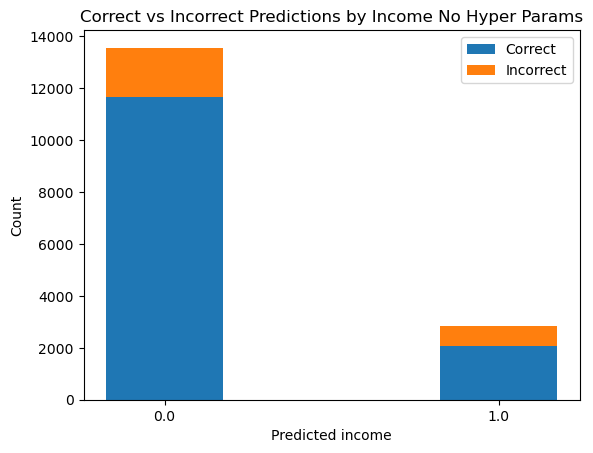

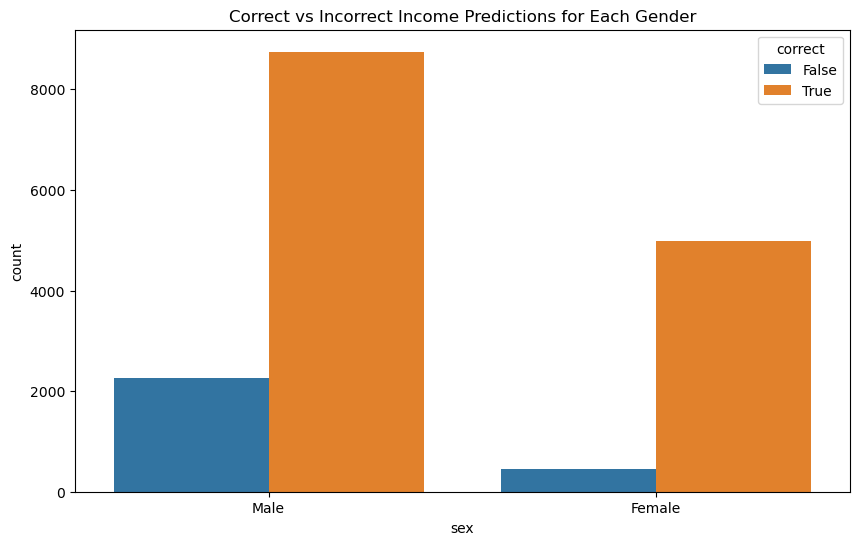

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, IndexToString
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


# Split the data into train and test
(train_data, test_data) = all_data.randomSplit([0.50, 0.50], seed=1234)

categorical_columns = ["workclass", "education", "marital_status", "occupation", "relationship", "race", "sex", "native_country"]

# StringIndexer for categorical columns
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index", handleInvalid="keep").fit(train_data) for column in categorical_columns]

# StringIndexer for the income column (we need to transform this independently as it's our target variable)
income_indexer = StringIndexer(inputCol="income", outputCol="income_index")


# Replace categorical columns with indexed columns
numeric_columns = [column+"_index" for column in categorical_columns]

# Include any other numeric columns from your DataFrame in your features
numeric_columns.extend(["age", "fnlwgt", "education_num", "capital_gain", "capital_loss", "hours_per_week"])

# VectorAssembler for feature columns
assembler = VectorAssembler(inputCols=numeric_columns, outputCol='features')

#print("Input Columns: ", assembler.getInputCols())
#print("Output Column: ", assembler.getOutputCol())

# Initialize Random Forest
lr = LogisticRegression(labelCol='income_index', featuresCol='features')

# Pipeline stages
stages = indexers + [assembler,income_indexer, lr]

# Initialize Pipeline
pipeline = Pipeline(stages=stages)


# Train model
model = pipeline.fit(train_data)

# Predict
predictions = model.transform(test_data)

# Define the evaluators
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="income_index", predictionCol="prediction", metricName="accuracy")
precision_evaluator = MulticlassClassificationEvaluator(labelCol="income_index", predictionCol="prediction", metricName="weightedPrecision")
recall_evaluator = MulticlassClassificationEvaluator(labelCol="income_index", predictionCol="prediction", metricName="weightedRecall")
f1_evaluator = MulticlassClassificationEvaluator(labelCol="income_index", predictionCol="prediction", metricName="f1")

# Compute metrics
accuracy = accuracy_evaluator.evaluate(predictions)
precision = precision_evaluator.evaluate(predictions)
recall = recall_evaluator.evaluate(predictions)
f1_score = f1_evaluator.evaluate(predictions)

# Print metrics
print("Accuracy: ", accuracy)
print("Weighted Precision: ", precision)
print("Weighted Recall: ", recall)
print("F1 Score: ", f1_score)

#SHOW Prediction Visuals & Graphs

# Define the converter
converter = IndexToString(inputCol="prediction", outputCol="predictedLabel", labels=model.stages[-2].labels)

# Apply the converter to the predictions
converted = converter.transform(predictions)

# Create a DataFrame with just the original and predicted values
results = converted.select("income", "predictedLabel").filter("income <> predictedLabel")

# Show the DataFrame
print("This model couldn't predict ",results.count(), " cases")


# Extract the labels and counts
label_counts = predictions.groupBy("prediction", "income_index").count().orderBy("prediction", "income_index").collect()
predicted_labels = sorted(set(row["prediction"] for row in label_counts))
actual_labels = sorted(set(row["income_index"] for row in label_counts))

# correct and incorrect count lists
correct_counts = [0] * len(predicted_labels)
incorrect_counts = [0] * len(predicted_labels)

# counts based on the predictions
for row in label_counts:
    pred_label_idx = predicted_labels.index(row["prediction"])
    if row["prediction"] == row["income_index"]:
        correct_counts[pred_label_idx] = row["count"]
    else:
        incorrect_counts[pred_label_idx] = row["count"]

# bar chart
plt.figure()
bar_width = 0.35
index = range(len(predicted_labels))
plt.bar(index, correct_counts, bar_width, label="Correct")
plt.bar(index, incorrect_counts, bar_width, bottom=correct_counts, label="Incorrect")
plt.xlabel("Predicted income")
plt.ylabel("Count")
plt.title("Correct vs Incorrect Predictions by Income No Hyper Params")
plt.xticks(index, predicted_labels)
plt.legend()
plt.show()



# Calculate the correct and incorrect predictions
results = converted.withColumn('correct', F.col('income') == F.col('predictedLabel'))
results_gender = results.groupBy('sex', 'correct').count().toPandas()

# Plot the results
plt.figure(figsize=(10,6))
sns.barplot(x='sex', y='count', hue='correct', data=results_gender)
plt.title('Correct vs Incorrect Income Predictions for Each Gender')
plt.show()

### => `Logistic Regression with Hyperparameters optimization`

In [ ]:

'''
lr = LogisticRegression(featuresCol='features', 
                        labelCol='label', 
                        predictionCol='prediction',
                        probabilityCol='probability',
                        maxIter=40, 
                        regParam=0.3, 
                        elasticNetParam=0)

'''

# Use ParamGridBuilder to construct a grid of parameters to search over
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]) \
    .addGrid(lr.maxIter, [40, 50, 60, 70]) \
    .addGrid(lr.elasticNetParam, [0,1,2]) \
    .build()

# Define cross-validation
crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)  # use 3+ folds in practice

# Run cross-validation, and choose the best set of parameters.

# Pipeline stages
stages = indexers + [assembler,income_indexer, lr, crossval]

# Initialize Pipeline
pipeline = Pipeline(stages=stages)

cv_model = pipeline.fit(train_data)

# Make predictions on test data using the model with the best set of parameters.
cv_predictions = cv_model.transform(test_data)

# Evaluate the model with cross-validation - accuracy
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
cv_accuracy = evaluator.evaluate(cv_predictions)

print("Accuracy with CV and ParamGrid: {:.2%}".format(cv_accuracy))

NameError: name 'lr' is not defined